In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import os
from util import *
from threading import Thread

In [2]:
df = compare_with_kraken("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_kraken2_nr/output.txt", "F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr_ncbi/raw_assignments.tsv", "F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr_ncbi/per_read_assignments.tsv")
df

Start reading kraken assignment
Start reading raw assignment
Start reading per read assignment
Joining raw assignment


KeyboardInterrupt: 

In [2]:
def read_kraken_assignment(path: str, target: dict):
    def split_kraken_assignment(assignment_string: str):
        assignments = {}
        for assignment in assignment_string.split():
            if assignment == "-:-":
                continue
            taxon_id, count = map(int, assignment.split(":"))
            assignments[taxon_id] = assignments.get(taxon_id, 0) + count
        return " ".join(f"{x}:{y}" for x, y in sorted(assignments.items(), key=lambda item: item[1], reverse=True))

    df = pd.read_csv(path, sep="\t", header=None,
                     names=["tag", "readId", "kraken2_assignment", "sequence_length", "assignments"], usecols=[1, 2, 3, 4], converters={"assignments": split_kraken_assignment})
    target["kraken"] = df

def read_raw_assignment(path: str, target: dict):
    df = pd.read_csv(path, sep="\t", header=None, skiprows=[0], names=["readId", "assignments"], usecols=[1])
    target["raw"] = df

def read_per_read_assignment(path: str, target: dict):
    df = pd.read_csv(path, sep="\t", skiprows=[0], header=0,  usecols=[1], converters={"assignments": lambda x: int(x.split(" ")[-1][1:-1])})
    target["per_read"] = df

def compare_with_kraken(path_kraken: str, path_raw_assignment: str, path_per_read_assignment):
    target = {}
    print("Start reading kraken assignment")
    kraken_assignment_processor = Thread(target=read_kraken_assignment, args=(path_kraken, target))
    kraken_assignment_processor.start()
    print("Start reading raw assignment")
    raw_assignment_processor = Thread(target=read_raw_assignment, args=(path_raw_assignment, target))
    raw_assignment_processor.start()
    print("Start reading per read assignment")
    per_read_assignment_processor = Thread(target=read_per_read_assignment, args=(path_per_read_assignment, target))
    per_read_assignment_processor.start()

    print("Joining raw assignment")
    raw_assignment_processor.join()
    print("Joining per read assignment")
    per_read_assignment_processor.join()
    print("Joining kraken assignment")
    kraken_assignment_processor.join()

    return target

df = compare_with_kraken("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_kraken2_nr/output.txt", "F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr_ncbi/raw_assignments.tsv", "F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr_ncbi/per_read_assignments.tsv")
df

Start reading kraken assignment
Start reading raw assignment
Start reading per read assignment
Joining raw assignment
Joining per read assignment
Joining kraken assignment


{'per_read':                    (superkingdom) Bacteria (2)
 0        (no rank) cellular organisms (131567)
 1        (no rank) cellular organisms (131567)
 2        (no rank) cellular organisms (131567)
 3           (kingdom) Pseudomonadati (3379134)
 4        (no rank) cellular organisms (131567)
 ...                                        ...
 1160520            (superkingdom) Bacteria (2)
 1160521            (superkingdom) Bacteria (2)
 1160522  (no rank) cellular organisms (131567)
 1160523            (superkingdom) Bacteria (2)
 1160524            (superkingdom) Bacteria (2)
 
 [1160525 rows x 1 columns],
 'raw':                                                assignments
 0        2:38 131567:37 1280:9 1239:3 1:3 2249226:2 205...
 1        131567:22 1:8 1613:3 2:2 4567:2 203682:1 33791...
 2        2:34 131567:25 1504319:3 2759:3 2485925:2 3379...
 3        131567:46 2:5 1:4 1236:3 497108:2 75105:1 2854...
 4        131567:18 2:10 1:4 2759:1 456327:1 1792290:1 3...
 ...          

In [40]:
test = {"a": 1, "b": 2, "C": 3, "d": 0}
" ".join("{}:{}".format(x, y) for x, y in dict(sorted(test.items(), key=lambda item: item[1], reverse=True)).items())

'C:3 b:2 a:1 d:0'

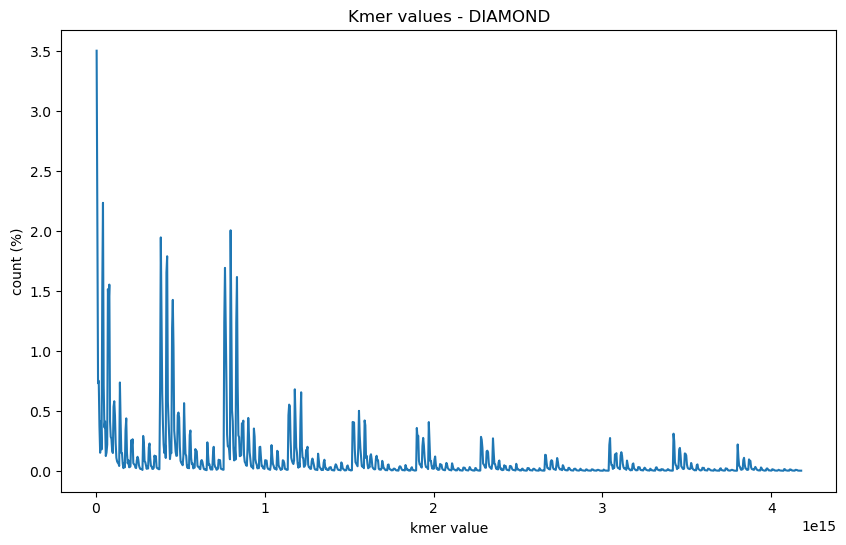

In [44]:
folder, title = "F:/Studium/Master/semester5/thesis/data/NCBI/nr90/index_diamond/statistics/", "Kmer values - DIAMOND"
#folder, title = "F:\\Studium\\Master\\semester5\\thesis\\data\\NCBI\\nr90\\index_etchebest\\statistics\\", "Kmer values - Etchbest et al."

kmer_histograms = []
for i, file in enumerate([x for x in os.listdir(folder) if x.endswith("kmer_histogram.tsv")]):
    if i == 0: kmer_histograms.append(pd.read_csv(folder + file, sep="\t", header=0, names=["bucket", file.split("_")[0]]))
    else:  kmer_histograms.append(pd.read_csv(folder + file, sep="\t", header=0, usecols=[1], names=[file.split("_")[0]]))

kmer_histogram = pd.concat(kmer_histograms, axis=1)
kmer_histogram["sum"] = kmer_histogram.iloc[:, 1:].sum(axis=1)
total_kmers = kmer_histogram["sum"].sum()
kmer_histogram["sum (%)"] = kmer_histogram["sum"] / total_kmers * 100
kmer_histogram

plt.figure(figsize=(10,6))
plt.plot(kmer_histogram["bucket"], kmer_histogram["sum (%)"])
plt.xlabel("kmer value")
plt.ylabel("count (%)")
plt.title(title)
plt.show()

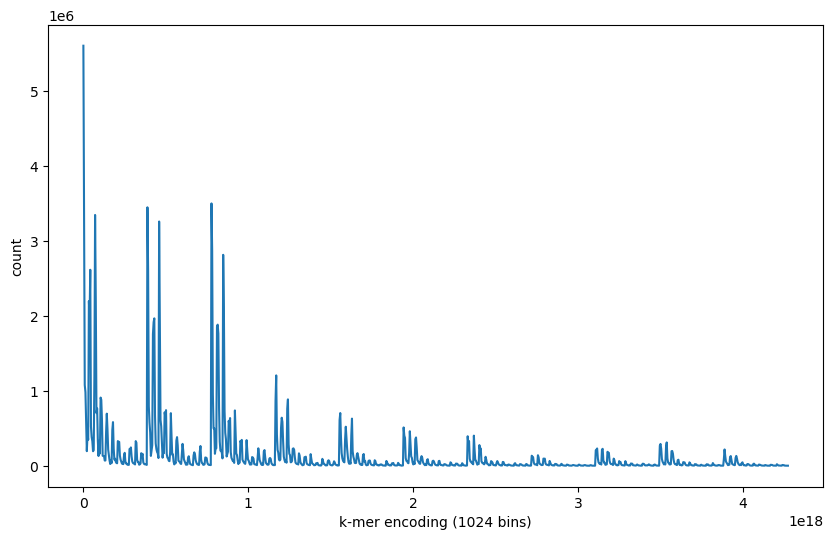

In [5]:
x = table.iloc[:,0]

plt.figure(figsize=(10,6))

# for column in table.columns[2:]:
#     plt.plot(x, table[column], label=column)

plt.plot(x, table["total"])
plt.xlabel("k-mer encoding (1024 bins)")
plt.ylabel("count")

# plt.legend()
plt.show()

In [25]:
base11_counts_zymo = pd.read_csv("C:\\Users\\nk035\\Documents\\diamer2\\statistics\\base11_counts_zymo.txt", sep=": ", header=None, names=["number", "count"])
# _2 = base11_counts_zymo["count"][1]
# base11_counts_zymo["count"][1] = base11_counts_zymo["count"][2]
# base11_counts_zymo["count"][2] = _2
# _7 = base11_counts_zymo["count"][9]
# base11_counts_zymo["count"][9] = base11_counts_zymo["count"][7]
# base11_counts_zymo["count"][7] = _7

zymno_mean = sum([i * base11_counts_zymo["count"][i] for i in range(len(base11_counts_zymo))]) / sum(base11_counts_zymo["count"])
base11_counts_zymo

C:\Users\nk035\AppData\Local\Temp\ipykernel_14568\175288690.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  base11_counts_zymo = pd.read_csv("C:\\Users\\nk035\\Documents\\diamer2\\statistics\\base11_counts_zymo.txt", sep=": ", header=None, names=["number", "count"])


,number,count
0,0,2920776439
1,1,1949437811
2,2,1830637054
3,3,514142039
4,4,513910784
5,5,450586530
6,6,249058792
7,7,275900774
8,8,262467223
9,9,150546931


In [26]:
base11_counts_nr100 = pd.read_csv("C:\\Users\\nk035\\Documents\\diamer2\\statistics\\base11_counts_nr100.txt", sep=": ", header=None, names=["number", "count"])

# _2 = base11_counts_nr100["count"][1]
# base11_counts_nr100["count"][1] = base11_counts_nr100["count"][2]
# base11_counts_nr100["count"][2] = _2
# _7 = base11_counts_nr100["count"][9]
# base11_counts_nr100["count"][9] = base11_counts_nr100["count"][7]
# base11_counts_nr100["count"][7] = _7

nr100_mean = sum([i * base11_counts_nr100["count"][i] for i in range(len(base11_counts_nr100))]) / sum(base11_counts_nr100["count"])
base11_counts_nr100

C:\Users\nk035\AppData\Local\Temp\ipykernel_14568\516717748.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  base11_counts_nr100 = pd.read_csv("C:\\Users\\nk035\\Documents\\diamer2\\statistics\\base11_counts_nr100.txt", sep=": ", header=None, names=["number", "count"])


,number,count
0,0,930399377
1,1,672806877
2,2,694816412
3,3,229603860
4,4,150393486
5,5,120829094
6,6,93554083
7,7,39872716
8,8,66460621
9,9,70456903


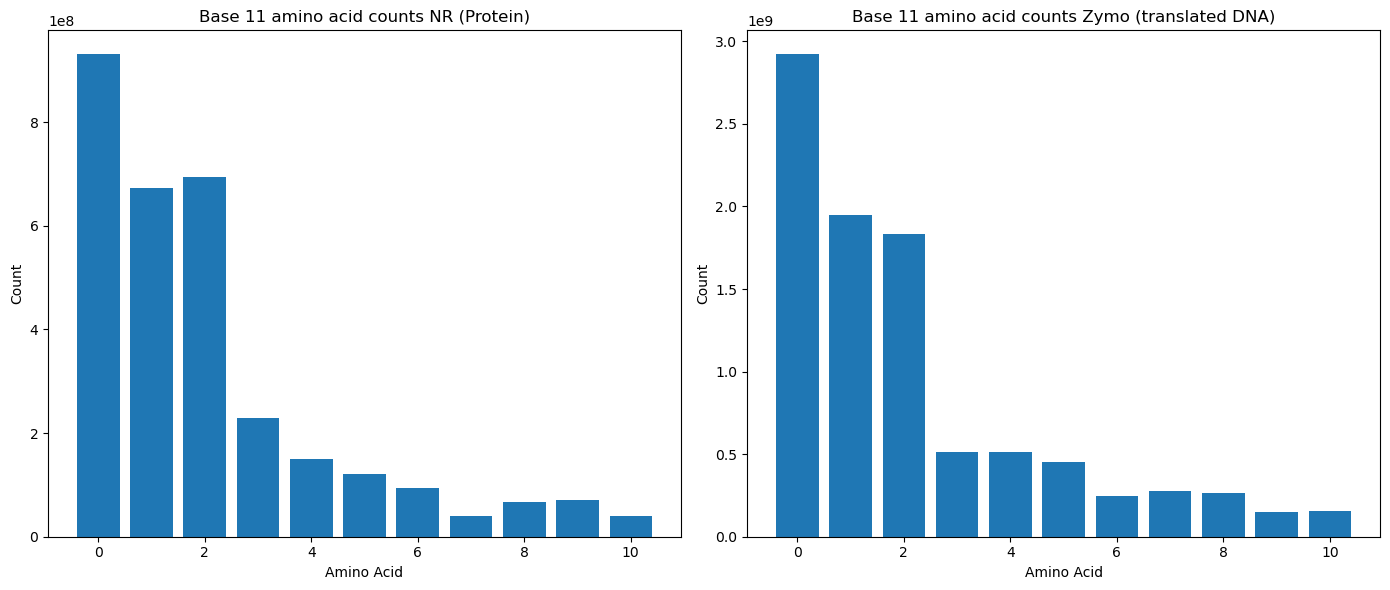

In [33]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first bar plot
ax1.bar(base11_counts_zymo["number"], base11_counts_zymo["count"])
#ax1.axvline(zymno_mean, color='r', linestyle='dashed', linewidth=1)
ax1.set_xlabel("Amino Acid")
ax1.set_ylabel("Count")
ax1.set_title("Base 11 amino acid counts Zymo (translated DNA)")

# Plot the second bar plot
ax2.bar(base11_counts_nr100["number"], base11_counts_nr100["count"])
#ax2.axvline(nr100_mean, color='r', linestyle='dashed', linewidth=1)
ax2.set_xlabel("Amino Acid")
ax2.set_ylabel("Count")
ax2.set_title("Base 11 amino acid counts NR (Protein)")

# Display the figure
plt.tight_layout()
plt.show()

In [86]:
rows = []

with open("F:\\Studium\\Master\\semester5\\thesis\\data\\NCBI\\kmer_occurrences_longspaced.txt") as f:
    for line in f:
        values = line.split("\t")
        entries = {int(key): int(value) for key, value in [entry.split(":") for entry in values[2:]]}
        entries["bucket"] = values[0].split(" ")[1]
        entries["average"] = float(values[1])
        rows.append(entries)

# sort the columns
occ_ls = pd.DataFrame(rows)
occ_ls = occ_ls.reindex(["bucket", "average"] + sorted(occ_ls.columns.drop(["bucket", "average"])), axis=1)

# calculate row sums and convert to percentages
row_sums = occ_ls.iloc[:, 2:].sum(axis=1)
occ_ls.iloc[:, 2:] = occ_ls.iloc[:, 2:].div(row_sums, axis=0) * 100
occ_ls['sum'] = row_sums
occ_ls = occ_ls.reindex(["bucket", "average", "sum"] + sorted(occ_ls.columns.drop(["bucket", "average", "sum"])), axis=1)

occ_ls

C:\Users\nk035\AppData\Local\Temp\ipykernel_11672\3722694197.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  occ_ls['sum'] = row_sums


,bucket,average,sum,1,2,3,4,5,6,7,...,3509314,3510650,3511356,3513133,3517585,3519056,3556295,9853585,10893928,396220181
0,0,11.935786,56620203.0,61.562139,15.388578,6.603268,3.742071,2.378944,1.656455,1.212161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002
1,1,4.984880,56615643.0,61.555374,15.387495,6.600234,3.748264,2.382446,1.660997,1.211195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN
2,2,5.228943,56623402.0,61.556595,15.387311,6.597737,3.744598,2.381794,1.659386,1.212666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN
3,3,5.271318,56620125.0,61.549993,15.391792,6.598290,3.745728,2.381000,1.659060,1.213959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5.042588,56628592.0,61.556026,15.389595,6.600212,3.744363,2.380909,1.657331,1.214358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,5.033649,56632988.0,61.541427,15.395207,6.602560,3.749287,2.379790,1.660409,1.212076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,100,5.195021,56608549.0,61.552685,15.382035,6.606550,3.748047,2.381958,1.660788,1.212421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,101,5.140609,56617011.0,61.553191,15.393026,6.598024,3.748163,2.376812,1.658018,1.212738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,102,4.811862,56610754.0,61.546455,15.388786,6.604492,3.747781,2.382164,1.658388,1.210169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


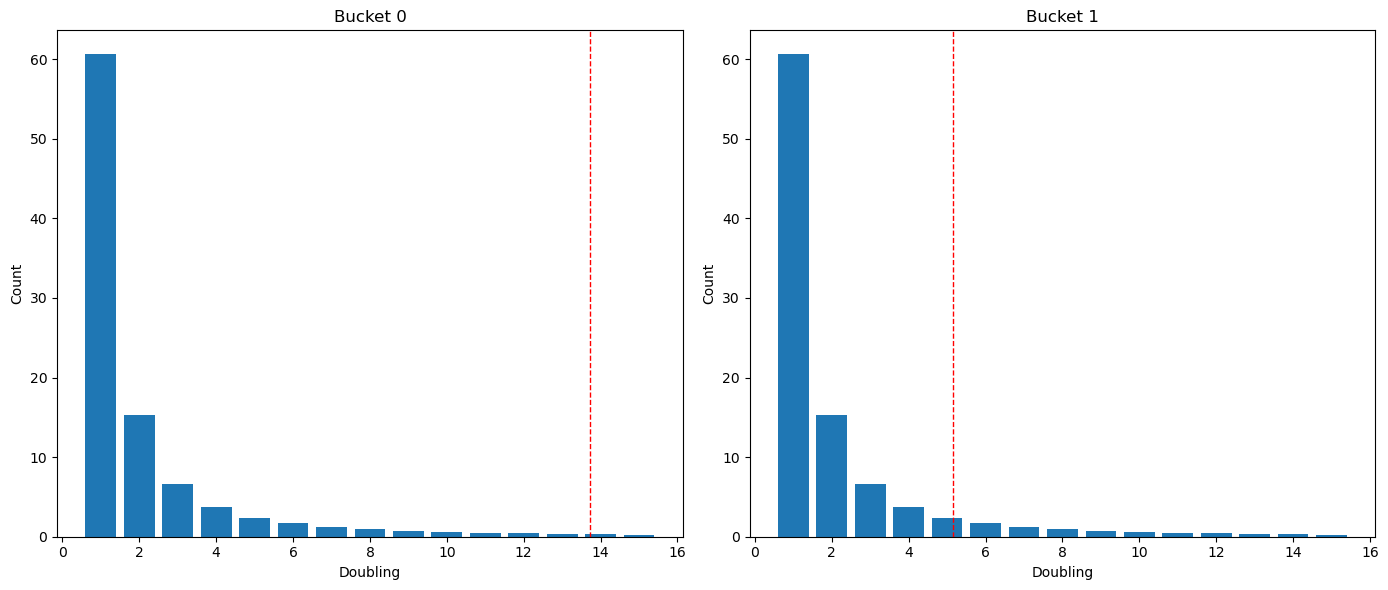

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first bar plot
ax1.bar(occ_ls.columns.drop(["bucket", "average", "sum"])[:15], occ_ls.iloc[0].drop(["bucket", "average", "sum"])[:15])
ax1.axvline(occ_ls.iloc[0]["average"], color='r', linestyle='dashed', linewidth=1)
ax1.set_xlabel("Doubling")
ax1.set_ylabel("Count")
ax1.set_title("Bucket 0")

# Plot the second bar plot
ax2.bar(occ_ls.columns.drop(["bucket", "average", "sum"])[:15], occ_ls.iloc[1].drop(["bucket", "average", "sum"])[:15])
ax2.axvline(occ_ls.iloc[1]["average"], color='r', linestyle='dashed', linewidth=1)
ax2.set_xlabel("Doubling")
ax2.set_ylabel("Count")
ax2.set_title("Bucket 1")

# Display the figure
plt.tight_layout()
plt.show()

In [87]:
rows = []

with open("F:\\Studium\\Master\\semester5\\thesis\\data\\NCBI\\kmer_occurrences_no_mask.txt") as f:
    for line in f:
        values = line.split("\t")
        entries = {int(key): int(value) for key, value in [entry.split(":") for entry in values[2:]]}
        entries["bucket"] = values[0].split(" ")[1]
        entries["average"] = float(values[1])
        rows.append(entries)

# sort the columns
occ = pd.DataFrame(rows)
occ = occ.reindex(["bucket", "average"] + sorted(occ.columns.drop(["bucket", "average"])), axis=1)

# calculate row sums and convert to percentages
row_sums = occ_ls.iloc[:, 2:].sum(axis=1)
occ.iloc[:, 2:] = occ.iloc[:, 2:].div(row_sums, axis=0) * 100
occ['sum'] = row_sums
occ = occ.reindex(["bucket", "average", "sum"] + sorted(occ.columns.drop(["bucket", "average", "sum"])), axis=1)

occ

C:\Users\nk035\AppData\Local\Temp\ipykernel_11672\3912453283.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  occ['sum'] = row_sums


,bucket,average,sum,1,2,3,4,5,6,7,...,3489842,3489927,3494317,3498621,3504883,3507749,3511327,3667978,3773432,472874882
0,0,13.715886,56620303.0,60.586347,15.260210,6.574280,3.743823,2.384947,1.663711,1.222277,...,NaN,0.000002,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,0.000002
1,1,5.141871,56615743.0,60.597740,15.268243,6.570655,3.746320,2.384570,1.668179,1.220678,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN
2,2,5.254500,56623502.0,60.586426,15.260402,6.575277,3.742232,2.384513,1.666845,1.220643,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN
3,3,5.557075,56620225.0,60.582329,15.264152,6.571535,3.743918,2.382550,1.663125,1.222090,...,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5.299953,56628692.0,60.573410,15.257903,6.576908,3.748411,2.380828,1.666551,1.221245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,5.284738,56624966.0,60.582509,15.261683,6.566280,3.740080,2.383650,1.669446,1.217555,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN,NaN
6,6,5.341595,56634795.0,60.572800,15.256893,6.572534,3.747532,2.387103,1.666603,1.218242,...,0.000002,NaN,0.000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,5.585336,56611893.0,60.618642,15.261599,6.564859,3.744423,2.385071,1.665510,1.218984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,5.220836,56615005.0,60.589932,15.259506,6.573944,3.750649,2.385059,1.668249,1.220337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,5.516894,56625094.0,60.586047,15.266288,6.581617,3.746336,2.381299,1.666572,1.219087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


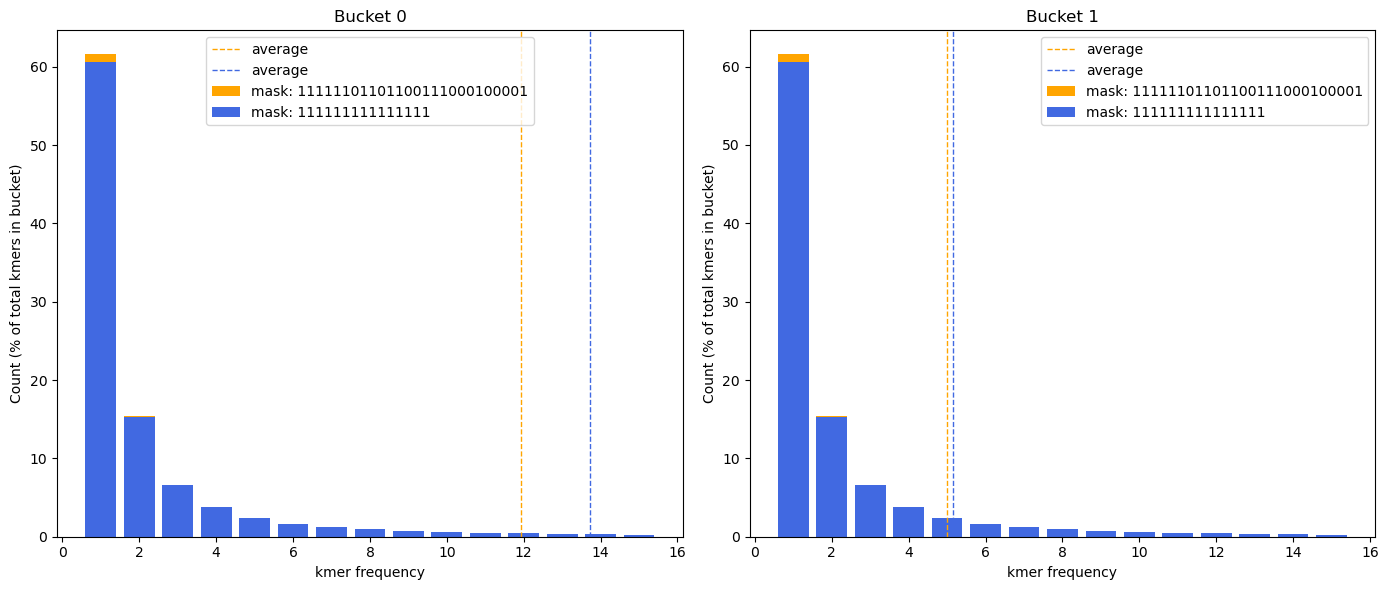

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first bar plot
ax1.bar(occ_ls.columns.drop(["bucket", "average", "sum"])[:15], occ_ls.iloc[0].drop(["bucket", "average", "sum"])[:15], label='mask: 11111101101100111000100001', color="orange")
ax1.bar(occ.columns.drop(["bucket", "average", "sum"])[:15], occ.iloc[0].drop(["bucket", "average", "sum"])[:15], label="mask: 111111111111111", color="royalblue")
ax1.axvline(occ_ls.iloc[0]["average"], color='orange', linestyle='dashed', linewidth=1, label="average")
ax1.axvline(occ.iloc[0]["average"], color='royalblue', linestyle='dashed', linewidth=1, label="average")
ax1.set_xlabel("kmer frequency")
ax1.set_ylabel("Count (% of total kmers in bucket)")
ax1.set_title("Bucket 0")
ax1.legend()

# Plot the second bar plot
ax2.bar(occ_ls.columns.drop(["bucket", "average", "sum"])[:15], occ_ls.iloc[1].drop(["bucket", "average", "sum"])[:15], label='mask: 11111101101100111000100001', color="orange")
ax2.bar(occ.columns.drop(["bucket", "average", "sum"])[:15], occ.iloc[1].drop(["bucket", "average", "sum"])[:15], label="mask: 111111111111111", color="royalblue")
ax2.axvline(occ_ls.iloc[1]["average"], color='orange', linestyle='dashed', linewidth=1, label="average")
ax2.axvline(occ.iloc[1]["average"], color='royalblue', linestyle='dashed', linewidth=1, label="average")
ax2.set_xlabel("kmer frequency")
ax2.set_ylabel("Count (% of total kmers in bucket)")
ax2.set_title("Bucket 1")
ax2.legend()

# Display the figure
plt.tight_layout()
plt.show()

In [18]:
per_taxon = pd.read_csv("F:\\Studium\\Master\\semester5\\thesis\\data\\test_dataset\\assignment_nr90_diamond_filteredByLikelihood\\per_taxon_assignments.tsv", header=0, sep="\t")
per_taxon = per_taxon[per_taxon["kmer count"] >= 1000].sort_values(["kmer count"], ascending=False).reset_index(drop=True)
per_taxon

,node id,rank,label,kmers in database,kmer count,kmer count (accumulated),OVO (0.10) read count,OVO (0.10) read count cumulative,OVO (0.10) read count (norm. kmers),OVO (0.10) read count (norm. kmers) cumulative,...,OVA (0.80) read count (norm. kmers) cumulative,OVA (0.90) read count,OVA (0.90) read count cumulative,OVA (0.90) read count (norm. kmers),OVA (0.90) read count (norm. kmers) cumulative,OVA (1.00) read count,OVA (1.00) read count cumulative,OVA (1.00) read count (norm. kmers),OVA (1.00) read count (norm. kmers) cumulative,normalized kmer count
0,2,superkingdom,Bacteria,100717184,82509577,236289537,145986,792138,189184,826807,...,340103,127508,340103,127508,340103,127508,340103,127508,340103,0.819220
1,131567,no rank,cellular organisms,34831614,40298483,291431838,265298,1099079,206409,1090334,...,1009188,637154,1009188,637154,1009188,637154,1009188,637154,1009188,1.156951
2,1,no rank,root,37773646,26704066,318467561,5964,1105467,10626,1105467,...,1105467,95862,1105467,95862,1105467,95862,1105467,95862,1105467,0.706950
3,1236,class,Gammaproteobacteria,35676907,15111629,76557248,8247,85380,4320,99583,...,9620,1111,9620,1111,9620,1111,9620,1111,9620,0.423569
4,543,family,Enterobacteriaceae,20777249,14132683,44534541,25588,64463,13078,67842,...,4376,1135,4376,1135,4376,1135,4376,1135,4376,0.680200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6190,550683,strain,Escherichia coli B921,540,1000,1000,0,0,3,3,...,0,0,0,0,0,0,0,0,0,1.851852
6191,83428,species,uncultured Bacillus sp.,364455,1000,1000,5,5,5,5,...,3,3,3,3,3,3,3,3,3,0.002744
6192,3032205,species,Lentzea sp. NBRC 105346,1142956,1000,1000,6,6,5,5,...,4,4,4,4,4,4,4,4,4,0.000875
6193,1071,species,Rhodopila globiformis,924422,1000,1000,2,2,7,7,...,2,2,2,2,2,2,2,2,2,0.001082


In [6]:
genera = {
    "Pseudomonas",
    "Escherichia",
    "Salmonella",
    "Staphylococcus",
    "Limosilactobacillus",
    "Enterococcus",
    "Listeria",
    "Bacillus",
    "Saccharomyces",
    "Cryptococcus"}
species = {
    "Pseudomonas aeruginosa",
    "Escherichia coli",
    "Salmonella enterica",
    "Staphylococcus aureus",
    "Limosilactobacillus fermentum",
    "Enterococcus faecalis",
    "Listeria monocytogenes",
    "Bacillus subtilis",
    "Saccharomyces cerevisiae",
    "Cryptococcus neoformans"}
paths_and_names = [
    ("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_kraken2_nr_processed/per_taxon_assignments.tsv", "NR kraken2 protein"),
    ("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr90/per_taxon_assignments.tsv", "NR90 DIAMOND"),
    ("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr90_diamond_filtered_5/per_taxon_assignments.tsv", "NR90 DIAMOND filtered (k>5)"),
    ("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr90_diamond_filteredE-9/per_taxon_assignments.tsv", "NR90 DIAMOND filtered (p<1e-9)"),
    ("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr90_diamond_filteredE-10/per_taxon_assignments.tsv", "NR90 DIAMOND filtered (p<1e-10)"),
    ("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr90_diamond_filteredE-11/per_taxon_assignments.tsv", "NR90 DIAMOND filtered (p<1e-11)"),
    ("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr90_diamond_filteredE-11_3/per_taxon_assignments.tsv", "NR90 DIAMOND filtered (p<1e-11, k>3)"),
    ("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr90_diamond_filteredE-12/per_taxon_assignments.tsv", "NR90 DIAMOND filtered (p<1e-12)"),
    ("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr90_diamond_filteredE-13/per_taxon_assignments.tsv", "NR90 DIAMOND filtered (p<1e-13)"),
    ("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr_ncbi/per_taxon_assignments.tsv", "NR DIAMOND"),
    ("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr_diamond_filteredE-12/per_taxon_assignments.tsv", "NR DIAMOND filtered (p<1e-12)"),
    ("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr_diamond_filteredE-11/per_taxon_assignments.tsv", "NR DIAMOND filtered (p<1e-11)"),
]

In [7]:
#dfs_and_names = [(read_per_taxon_assignment(path), name) for path, name in paths_and_names]
true_assigned_reads_species_and_names = [(true_assigned_reads(read_per_taxon_assignment(path), species, "species"), name) for path, name in paths_and_names]

In [8]:
#true_assigned_reads_species_and_names = [(true_assigned_reads(df, species, "species"), name) for df, name in dfs_and_names]
for df, name in true_assigned_reads_species_and_names:
    df.index = df["assignment algorithm"].apply(lambda x: x.replace("0000", "").replace("ratio: ", "").replace("(accumulated)", "cumulative"))
    df["true assigned reads"] = df["true assigned reads"] / 1160526 * 100

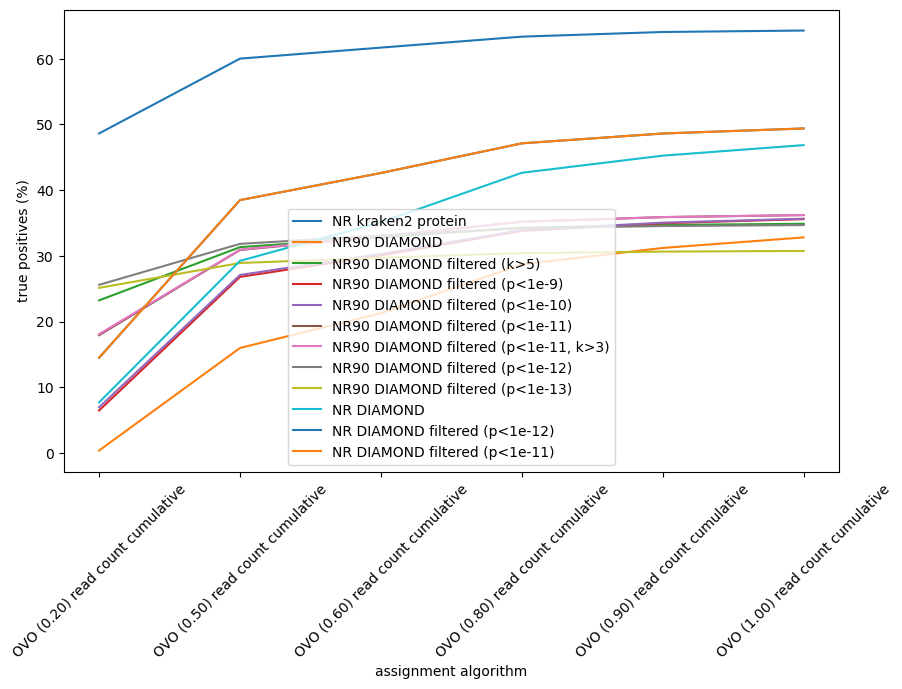

In [11]:
# true_assigned_reads_genera = true_assigned_reads(df, genera, "genus")
# # true_assigned_reads_df = pd.merge(true_assigned_reads_species, true_assigned_reads_genera, left_on="assignment algorithm", right_on="assignment algorithm")
# # true_assigned_reads_df
plt.figure(figsize=(10,6))
for df, name in true_assigned_reads_species_and_names:
    plt.plot(df.loc[[
        "OVO (0.20) read count cumulative",
        "OVO (0.50) read count cumulative",
        "OVO (0.60) read count cumulative",
        "OVO (0.80) read count cumulative",
        "OVO (0.90) read count cumulative",
        "OVO (1.00) read count cumulative"],"true assigned reads"], label=name)
plt.xticks(rotation=45)
plt.xlabel("assignment algorithm")
plt.ylabel("true positives (%)")
plt.legend()
plt.show()

In [11]:
per_taxon = pd.read_csv("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr90_diamond_filtered_5/per_taxon_assignments.tsv", header=0, sep="\t")

In [12]:
species = {
    "Pseudomonas aeruginosa",
    "Escherichia coli",
    "Salmonella enterica",
    "Staphylococcus aureus",
    "Limosilactobacillus fermentum",
    "Enterococcus faecalis",
    "Listeria monocytogenes",
    "Bacillus subtilis",
    "Saccharomyces cerevisiae",
    "Cryptococcus neoformans"}
species_ids = {
    "Pseudomonas aeruginosa": 287,
    "Escherichia coli": 562,
    "Salmonella enterica": 28901,
    "Staphylococcus aureus": 1280,
    "Limosilactobacillus fermentum": 1613,
    "Enterococcus faecalis": 1351,
    "Listeria monocytogenes": 1639,
    "Bacillus subtilis": 1423,
    "Saccharomyces cerevisiae": 4932,
    "Cryptococcus neoformans": 5207
}
genera = {
    "Pseudomonas",
    "Escherichia",
    "Salmonella",
    "Staphylococcus",
    "Limosilactobacillus",
    "Enterococcus",
    "Listeria",
    "Bacillus",
    "Saccharomyces",
    "Cryptococcus"}

level = "species"
min_colum_index = 3
indices = pd.DataFrame(index=per_taxon.columns[min_colum_index:])
for column in per_taxon.columns[min_colum_index:]:
    per_taxon_sorted = per_taxon[per_taxon['rank'] == level].sort_values([column], ascending=False).reset_index(drop=True)
    for species_ in species:
        index_value = per_taxon_sorted[per_taxon_sorted["label"] == species_].index[0]
        indices.loc[column, species_] = index_value
indices["sum"] = indices.sum(axis=1)
indices

,Listeria monocytogenes,Enterococcus faecalis,Escherichia coli,Pseudomonas aeruginosa,Bacillus subtilis,Staphylococcus aureus,Limosilactobacillus fermentum,Cryptococcus neoformans,Saccharomyces cerevisiae,Salmonella enterica,sum
kmers in database,7387.0,2126.0,105.0,477.0,5712.0,3799.0,10919.0,6964.0,5986.0,1046.0,44521.0
kmer count,7.0,5.0,0.0,1.0,11.0,3.0,2.0,16.0,12.0,6.0,63.0
kmer count (accumulated),7.0,5.0,1.0,2.0,12.0,4.0,3.0,10.0,13.0,0.0,57.0
OVO (0.10) read count,3.0,2.0,6.0,4.0,9.0,1.0,0.0,16.0,7.0,8.0,56.0
OVO (0.10) read count cumulative,3.0,4.0,6.0,5.0,9.0,2.0,0.0,10.0,8.0,1.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...
OVA (1.00) read count,15.0,4.0,7.0,20.0,105.0,1.0,0.0,55.0,243.0,12.0,462.0
OVA (1.00) read count cumulative,11.0,4.0,6.0,18.0,50.0,1.0,0.0,15.0,163.0,2.0,270.0
OVA (1.00) read count (norm. kmers),15.0,4.0,7.0,20.0,105.0,1.0,0.0,55.0,243.0,12.0,462.0
OVA (1.00) read count (norm. kmers) cumulative,11.0,4.0,6.0,18.0,50.0,1.0,0.0,15.0,163.0,2.0,270.0


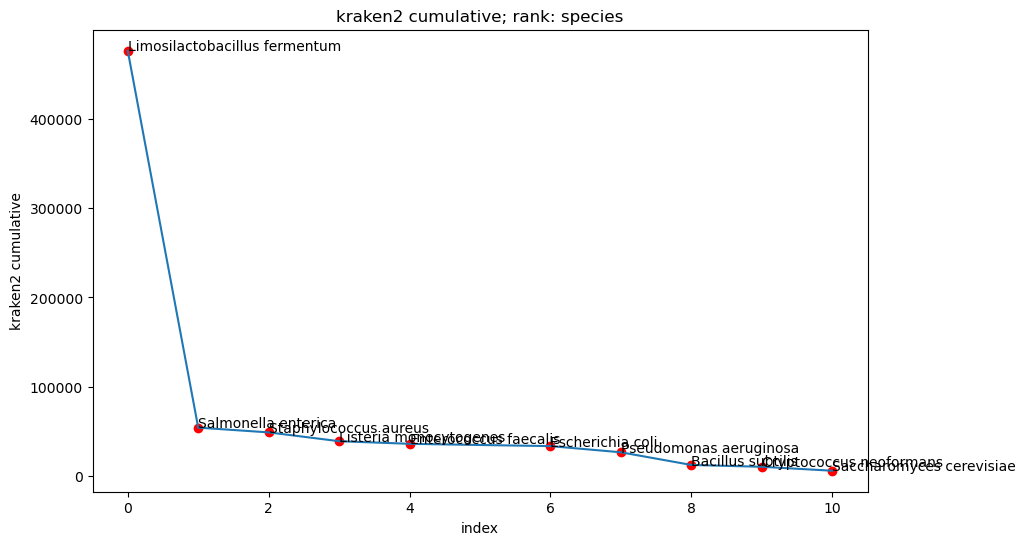

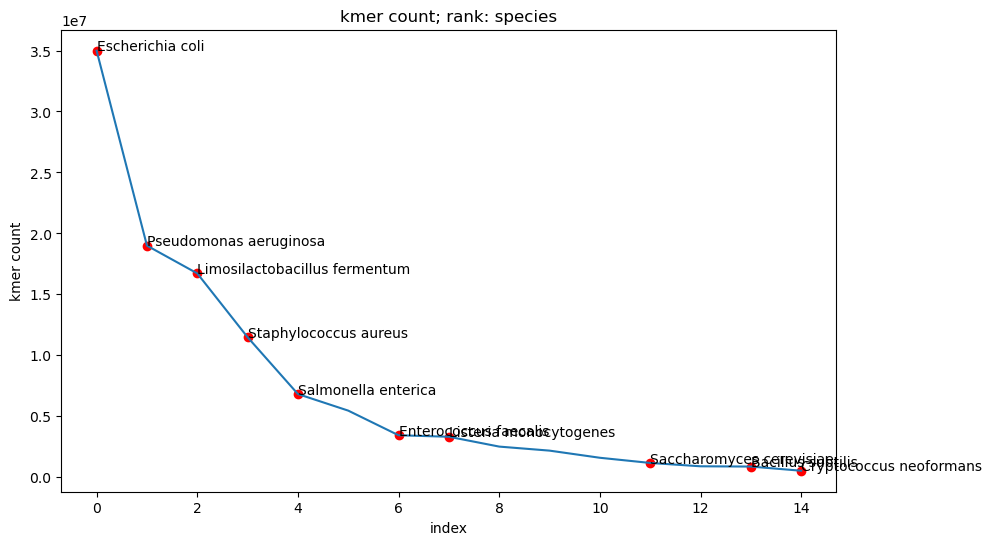

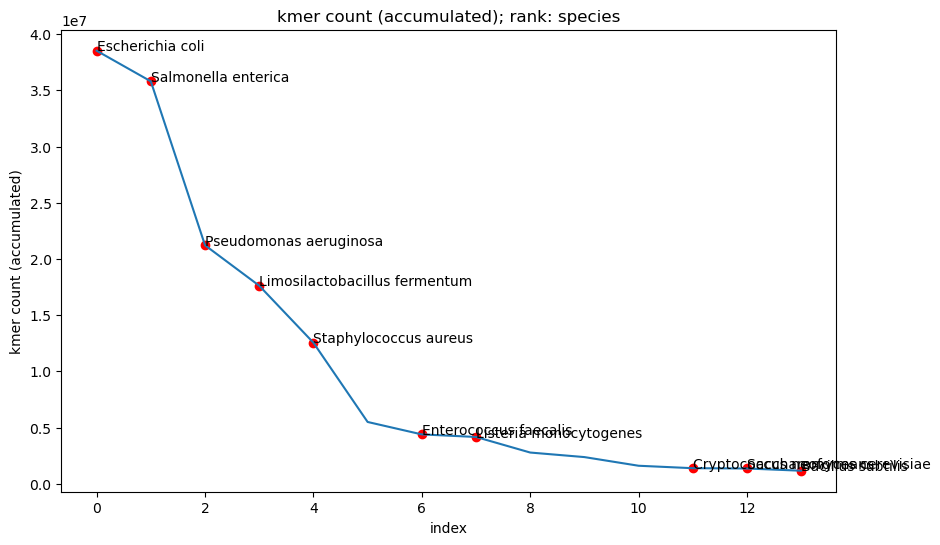

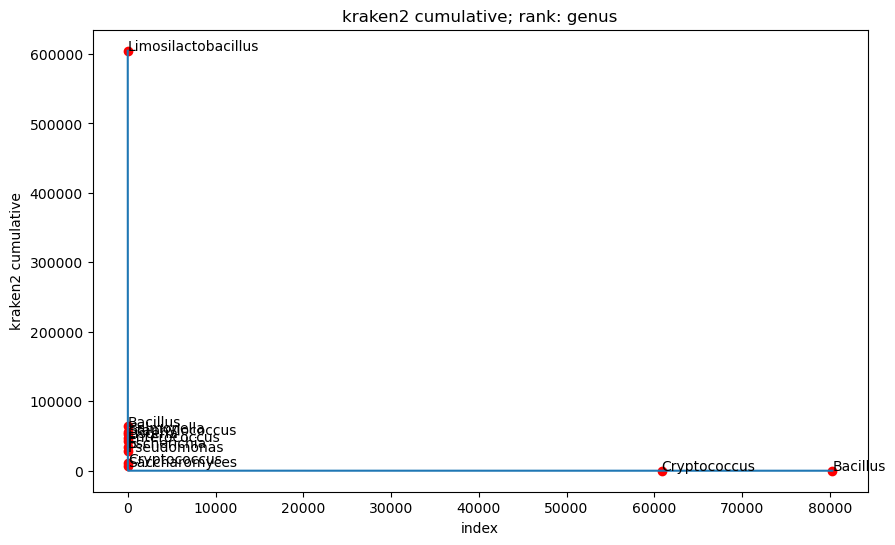

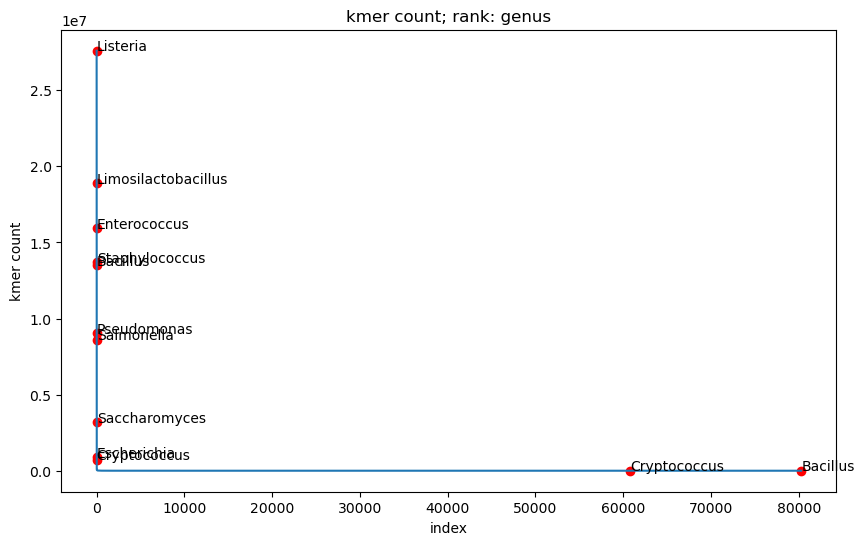

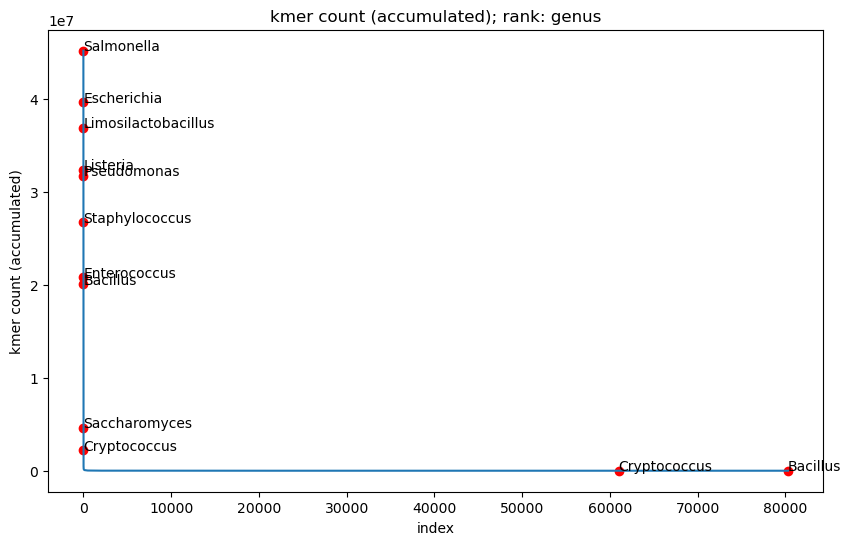

In [7]:
def generate_plot_of_values(data, value, rank, labels):
    data_ = data[["label", value]].loc[(per_taxon["rank"] == rank)].sort_values(value, ascending=False).reset_index(drop=True)
    only_labels = data_[data_["label"].isin(labels)]
    max_index = only_labels.index.max() + 1
    plt.figure(figsize=(10,6))
    plt.title(value + "; rank: " + rank)
    plt.plot(data_[value][:max_index])
    plt.xlabel("index")
    plt.ylabel(value)
    plt.scatter(only_labels.index, only_labels[value], color="red")
    for i, row in only_labels.iterrows():
        plt.annotate(row["label"], (i, row[value]))
    plt.show()

for column in per_taxon.columns[4:]:
    generate_plot_of_values(per_taxon, column, "species", species)

for column in per_taxon.columns[4:]:
    generate_plot_of_values(per_taxon, column, "genus", genera)

In [15]:
per_taxon = pd.read_csv("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_kraken2_nr_processed/per_taxon_assignments.tsv", header=0, sep="\t")
per_taxon = per_taxon[(per_taxon['rank'] == "species") & (per_taxon["kmer count"] >= 1000)].sort_values(["kmer count"], ascending=False).reset_index(drop=True)
per_taxon

,node id,rank,label,kmer count,kmer count (accumulated),kraken2,kraken2 cumulative,OVO (0.20) read count,OVO (0.20) read count cumulative,OVO (0.50) read count,OVO (0.50) read count cumulative,OVO (0.60) read count,OVO (0.60) read count cumulative,OVO (0.80) read count,OVO (0.80) read count cumulative,OVO (0.90) read count,OVO (0.90) read count cumulative,OVO (1.00) read count,OVO (1.00) read count cumulative
0,562,species,Escherichia coli,34984626,38521178,6833,33706,14862,16768,22610,31197,19962,32147,13772,33156,9758,33499,6829,33673
1,287,species,Pseudomonas aeruginosa,18997747,21216028,5493,26776,17035,21431,14340,25557,12377,25989,8758,26468,6877,26641,5476,26734
2,1613,species,Limosilactobacillus fermentum,16720341,17618521,412613,475959,327379,372215,393382,449550,402527,461243,409970,471626,413224,476180,413595,477040
3,1280,species,Staphylococcus aureus,11484948,12548442,21312,49049,30305,38282,31350,45872,29305,47087,25115,48342,22518,48848,21316,49017
4,28901,species,Salmonella enterica,6824691,35797279,1223,54371,1979,44232,1537,51749,1431,52815,1339,53972,1267,54415,1235,54593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12519,2058314,species,Flavobacterium sp. ALD4,1000,1000,1,1,0,0,0,0,0,0,0,0,1,1,1,1
12520,2817775,species,Mycoplana sp. BE70,1000,1000,0,0,1,1,1,1,1,1,1,1,1,1,1,1
12521,79879,species,Evansella clarkii,1000,1000,1,1,0,0,0,0,0,0,2,2,2,2,2,2
12522,2849652,species,Duganella violaceipulchra,1000,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
level = "species"
min_colum_index = 3
indices = pd.DataFrame(index=per_taxon.columns[min_colum_index:])
for column in per_taxon.columns[min_colum_index:]:
    per_taxon_sorted = per_taxon[per_taxon['rank'] == level].sort_values([column], ascending=False).reset_index(drop=True)
    for species_ in species:
        index_value = per_taxon_sorted[per_taxon_sorted["label"] == species_].index[0]
        indices.loc[column, species_] = index_value
indices["sum"] = indices.sum(axis=1)
indices

,Salmonella enterica,Enterococcus faecalis,Staphylococcus aureus,Bacillus subtilis,Cryptococcus neoformans,Listeria monocytogenes,Saccharomyces cerevisiae,Limosilactobacillus fermentum,Escherichia coli,Pseudomonas aeruginosa,sum
kmer count,4.0,6.0,3.0,13.0,14.0,7.0,11.0,2.0,0.0,1.0,61.0
kmer count (accumulated),1.0,6.0,4.0,13.0,11.0,7.0,12.0,3.0,0.0,2.0,59.0
kraken2,11.0,4.0,2.0,6.0,18.0,3.0,10.0,0.0,5.0,7.0,66.0
kraken2 cumulative,1.0,4.0,2.0,8.0,9.0,3.0,10.0,0.0,6.0,7.0,50.0
OVO (0.20) read count,9.0,2.0,1.0,8.0,12.0,3.0,7.0,0.0,5.0,4.0,51.0
OVO (0.20) read count cumulative,1.0,3.0,2.0,10.0,8.0,4.0,9.0,0.0,6.0,5.0,48.0
OVO (0.50) read count,11.0,3.0,1.0,7.0,12.0,4.0,8.0,0.0,2.0,6.0,54.0
OVO (0.50) read count cumulative,1.0,4.0,2.0,9.0,8.0,3.0,10.0,0.0,5.0,6.0,48.0
OVO (0.60) read count,11.0,4.0,1.0,7.0,13.0,5.0,9.0,0.0,2.0,6.0,58.0
OVO (0.60) read count cumulative,1.0,4.0,2.0,9.0,8.0,3.0,10.0,0.0,5.0,7.0,49.0


In [8]:
per_taxon = pd.read_csv("F:\\Studium\\Master\\semester5\\thesis\\data\\test_dataset\\assignment_nr_ncbi_longspaced\\per_taxon_assignments.tsv", header=0, sep="\t")
per_taxon[per_taxon['rank'] == "species"].sort_values(["kmer count"], ascending=False).reset_index(drop=True)

,node id,rank,label,kmers in database,kmer count,kmer count (accumulated),OVO (0.20) read count,OVO (0.20) read count cumulative,OVO (0.20) read count (norm. kmers),OVO (0.20) read count (norm. kmers) cumulative,...,OVA (0.80) read count (norm. kmers) cumulative,OVA (0.90) read count,OVA (0.90) read count cumulative,OVA (0.90) read count (norm. kmers),OVA (0.90) read count (norm. kmers) cumulative,OVA (1.00) read count,OVA (1.00) read count cumulative,OVA (1.00) read count (norm. kmers),OVA (1.00) read count (norm. kmers) cumulative,normalized kmer count
0,287,species,Pseudomonas aeruginosa,18215662,12921717,14439466,4220,5452,5030,9918,...,4,4,4,4,4,4,4,4,4,0.709374
1,562,species,Escherichia coli,40381490,12663844,13714272,7728,9196,10413,16840,...,4,3,4,3,4,3,4,3,4,0.313605
2,1280,species,Staphylococcus aureus,9337298,4167914,4419691,1331,1625,8147,20976,...,108,104,108,104,108,104,108,104,108,0.446373
3,28901,species,Salmonella enterica,22121878,4021667,13783632,1026,24945,543,28238,...,12,7,12,7,12,7,12,7,12,0.181796
4,1613,species,Limosilactobacillus fermentum,861803,3747835,4029077,23602,26742,12927,42382,...,242,219,242,219,242,219,242,219,242,4.348830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160659,161627,species,Plectrophenax nivalis,22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2160660,371921,species,Plectrophenax hyperboreus,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2160661,1002905,species,Ploceus sp. GGS-2011,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2160662,1002906,species,Quelea sp. GGS-2011,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [9]:
level = "species"
min_colum_index = 4
indices = pd.DataFrame(index=per_taxon.columns[min_colum_index:])
for column in per_taxon.columns[min_colum_index:]:
    per_taxon_sorted = per_taxon[per_taxon['rank'] == level].sort_values([column], ascending=False).reset_index(drop=True)
    for species_ in species:
        index_value = per_taxon_sorted[per_taxon_sorted["label"] == species_].index[0]
        indices.loc[column, species_] = index_value
indices["sum"] = indices.sum(axis=1)
indices

,Cryptococcus neoformans,Escherichia coli,Bacillus subtilis,Listeria monocytogenes,Staphylococcus aureus,Enterococcus faecalis,Limosilactobacillus fermentum,Salmonella enterica,Pseudomonas aeruginosa,Saccharomyces cerevisiae,sum
kmer count,86.0,1.0,57.0,9.0,2.0,18.0,4.0,3.0,0.0,47.0,227.0
kmer count (accumulated),30.0,2.0,43.0,6.0,3.0,17.0,4.0,1.0,0.0,40.0,146.0
OVO (0.20) read count,145.0,1.0,12.0,7.0,3.0,5.0,0.0,4.0,2.0,64.0,243.0
OVO (0.20) read count cumulative,49.0,2.0,12.0,7.0,4.0,5.0,0.0,1.0,3.0,47.0,130.0
OVO (0.20) read count (norm. kmers),101.0,1.0,9.0,5.0,2.0,3.0,0.0,6.0,4.0,12.0,143.0
...,...,...,...,...,...,...,...,...,...,...,...
OVA (1.00) read count,741784.0,112.0,1066.0,40.0,1.0,60.0,0.0,35.0,77.0,730059.0,1473234.0
OVA (1.00) read count cumulative,741794.0,70.0,187.0,27.0,1.0,60.0,0.0,16.0,81.0,730071.0,1472307.0
OVA (1.00) read count (norm. kmers),741784.0,112.0,1066.0,40.0,1.0,60.0,0.0,35.0,77.0,730059.0,1473234.0
OVA (1.00) read count (norm. kmers) cumulative,741794.0,70.0,187.0,27.0,1.0,60.0,0.0,16.0,81.0,730071.0,1472307.0


In [2]:
per_taxon = pd.read_csv("F:\\Studium\\Master\\semester5\\thesis\\data\\test_dataset\\assignment_nr_ncbi_zhang\\per_taxon_assignments.tsv", header=0, sep="\t")
per_taxon[per_taxon['rank'] == "species"].sort_values(["kmer count"], ascending=False).reset_index(drop=True)

,node id,rank,label,kmers in database,kmer count,kmer count (accumulated),OVO (0.20) read count,OVO (0.20) read count cumulative,OVO (0.20) read count (norm. kmers),OVO (0.20) read count (norm. kmers) cumulative,...,OVA (0.80) read count (norm. kmers) cumulative,OVA (0.90) read count,OVA (0.90) read count cumulative,OVA (0.90) read count (norm. kmers),OVA (0.90) read count (norm. kmers) cumulative,OVA (1.00) read count,OVA (1.00) read count cumulative,OVA (1.00) read count (norm. kmers),OVA (1.00) read count (norm. kmers) cumulative,normalized kmer count
0,562,species,Escherichia coli,41789935,14127688,15369707,7651,8980,10969,17464,...,0,0,0,0,0,0,0,0,0,0.338064
1,287,species,Pseudomonas aeruginosa,18627557,13963145,15637973,4526,5804,5406,10279,...,2,2,2,2,2,2,2,2,2,0.749596
2,1280,species,Staphylococcus aureus,9559285,4421808,4736959,987,1226,8337,21155,...,45,43,45,43,45,43,45,43,45,0.462567
3,1613,species,Limosilactobacillus fermentum,880208,4243900,4569490,20410,23261,11361,42274,...,61,50,61,50,61,50,61,50,61,4.821474
4,28901,species,Salmonella enterica,22579016,4161874,15549294,973,24833,508,28950,...,9,2,9,2,9,2,9,2,9,0.184325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2174484,1497527,species,Emberiza socotrana,28,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2174485,1402987,species,Emberiza goslingi,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2174486,12375,species,Lactococcus phage (ISOLATE 7-9),22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2174487,12374,species,Lactococcus phage,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [4]:
per_taxon[per_taxon['rank'] == "species"].sort_values(["kmer count"], ascending=False).reset_index(drop=True)
level = "species"
min_colum_index = 4
indices = pd.DataFrame(index=per_taxon.columns[min_colum_index:])
for column in per_taxon.columns[min_colum_index:]:
    per_taxon_sorted = per_taxon[per_taxon['rank'] == level].sort_values([column], ascending=False).reset_index(
        drop=True)
    for species_ in species:
        index_value = per_taxon_sorted[per_taxon_sorted["label"] == species_].index[0]
        indices.loc[column, species_] = index_value
indices["sum"] = indices.sum(axis=1)
indices

,Salmonella enterica,Saccharomyces cerevisiae,Staphylococcus aureus,Escherichia coli,Pseudomonas aeruginosa,Bacillus subtilis,Enterococcus faecalis,Limosilactobacillus fermentum,Listeria monocytogenes,Cryptococcus neoformans,sum
kmer count,4.0,47.0,2.0,0.0,1.0,64.0,21.0,3.0,11.0,85.0,238.0
kmer count (accumulated),1.0,40.0,3.0,2.0,0.0,48.0,16.0,4.0,6.0,30.0,150.0
OVO (0.20) read count,4.0,63.0,3.0,1.0,2.0,12.0,6.0,0.0,7.0,151.0,249.0
OVO (0.20) read count cumulative,0.0,47.0,4.0,2.0,3.0,12.0,5.0,1.0,7.0,30.0,111.0
OVO (0.20) read count (norm. kmers),6.0,13.0,2.0,1.0,3.0,8.0,4.0,0.0,5.0,125.0,167.0
...,...,...,...,...,...,...,...,...,...,...,...
OVA (1.00) read count,80.0,735575.0,1.0,217412.0,56.0,299706.0,88.0,0.0,86.0,747381.0,2000385.0
OVA (1.00) read count cumulative,13.0,735581.0,1.0,217420.0,69.0,299714.0,67.0,0.0,71.0,215.0,1253151.0
OVA (1.00) read count (norm. kmers),80.0,735575.0,1.0,217412.0,56.0,299706.0,88.0,0.0,86.0,747381.0,2000385.0
OVA (1.00) read count (norm. kmers) cumulative,13.0,735581.0,1.0,217420.0,69.0,299714.0,67.0,0.0,71.0,215.0,1253151.0
